In [21]:
import os
import numpy as np
import cv2
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

root_folder = r'data'
target_size = 64

cropped_images = []
for subdir in os.listdir(root_folder):
    subdir_path = os.path.join(root_folder, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for subdir2 in os.listdir(subdir_path):
        subdir2_path = os.path.join(subdir_path, subdir2)
        if not os.path.isdir(subdir2_path):
            continue

        stacked_img = np.empty([512, 512, 31])
        for i in range(1, 32):
            img_path = os.path.join(subdir2_path, f"{subdir2}_{i:02d}.png")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            stacked_img[:, :, i-1] = img

        # Loop through the stacked image and extract crops
        for h in range(0, 512-target_size+1, target_size//2):
            for w in range(0, 512-target_size+1, target_size//2):
                cropped_img = stacked_img[h:h+target_size, w:w+target_size, :]
                cropped_images.append(cropped_img)

cropped_images = np.array(cropped_images)


In [22]:
print(cropped_images)

[[[[  4.   3.   2. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   ...
   [ 14.  10.   6. ...   2.   4.   7.]
   [ 15.  10.   5. ...   2.   4.   7.]
   [ 14.  10.   6. ...   2.   4.   7.]]

  [[  4.   3.   2. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   6.   0.]
   [  0.   0.   0. ...   0.   6.   0.]
   ...
   [ 18.  12.   7. ...   3.   5.   9.]
   [ 18.  12.   7. ...   3.   5.   9.]
   [ 17.  12.   7. ...   3.   5.   9.]]

  [[  4.   3.   2. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   ...
   [ 18.  13.   8. ...   4.   6.  10.]
   [ 18.  12.   7. ...   4.   5.  10.]
   [ 18.  12.   6. ...   3.   5.   9.]]

  ...

  [[  3.   2.   1. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   ...
   [ 19.  14.   8. ...   4.   7.  12.]
   [ 20.  14.   8. ...   5.   7.  12.]
   [ 19.  14.   8. ...   4.   6.  11.]]

  [[  3.   2.   0. ..

In [23]:
LowResHSI = []
HiResRGB = []

for img in cropped_images:
    # Low-resolution HSI
    low_res_img = cv2.resize(img, (8, 8), interpolation=cv2.INTER_AREA)
    LowResHSI.append(low_res_img)
    
    # High-resolution RGB
    high_res_img = np.zeros((64, 64, 3))
    for i in range(3):
        high_res_img[:,:,i] = np.mean(img[:, :, i*10:(i+1)*10], axis=2)
    HiResRGB.append(high_res_img)

LowResHSI = np.array(LowResHSI)
HiResRGB = np.array(HiResRGB)

print("low_res_images images shape:", LowResHSI.shape)
print("high_res_images images shape:", HiResRGB.shape)

low_res_images images shape: (7200, 8, 8, 31)
high_res_images images shape: (7200, 64, 64, 3)


In [24]:
# Create the target dataset (original high resolution hyperspectral images)
y = cropped_images

# Create the input dataset (low resolution hyperspectral images and high resolution RGB images)
# No need to concatenate the inputs, keep them separate
X_low_res_hsi = LowResHSI
X_hi_res_rgb = HiResRGB

print("Low resolution HSI images shape:", X_low_res_hsi.shape)
print("High resolution RGB images shape:", X_hi_res_rgb.shape)
print("Target images shape:", y.shape)

from sklearn.model_selection import train_test_split

# Split the datasets into training and testing sets
X_low_res_hsi_train, X_low_res_hsi_test, y_train, y_test = train_test_split(X_low_res_hsi, y, test_size=0.2, random_state=42)
X_hi_res_rgb_train, X_hi_res_rgb_test = train_test_split(X_hi_res_rgb, test_size=0.2, random_state=42)


print(f"X_low_res_hsi_train shape: {X_low_res_hsi_train.shape}")
print(f"X_hi_res_rgb_train shape: {X_hi_res_rgb_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_low_res_hsi_test shape: {X_low_res_hsi_test.shape}")
print(f"X_hi_res_rgb_test shape: {X_hi_res_rgb_test.shape}")
print(f"y_test shape: {y_test.shape}")

Low resolution HSI images shape: (7200, 8, 8, 31)
High resolution RGB images shape: (7200, 64, 64, 3)
Target images shape: (7200, 64, 64, 31)
X_low_res_hsi_train shape: (5760, 8, 8, 31)
X_hi_res_rgb_train shape: (5760, 64, 64, 3)
y_train shape: (5760, 64, 64, 31)
X_low_res_hsi_test shape: (1440, 8, 8, 31)
X_hi_res_rgb_test shape: (1440, 64, 64, 3)
y_test shape: (1440, 64, 64, 31)


In [25]:
# Normalize the input data

# Calculate the maximum pixel value
max_pixel_value = 255
X_low_res_hsi_train = X_low_res_hsi_train / max_pixel_value
X_low_res_hsi_test = X_low_res_hsi_test / max_pixel_value

max_pixel_value = 255
X_hi_res_rgb_train = X_hi_res_rgb_train / max_pixel_value
X_hi_res_rgb_test = X_hi_res_rgb_test / max_pixel_value

max_pixel_value = 255
y_train = y_train / max_pixel_value
y_test = y_test / max_pixel_value

In [30]:
def create_model():
    # Define the input layers
    hi_res_rgb_input = Input(shape=(64, 64, 3))
    low_res_hsi_input = Input(shape=(8, 8, 31))

    # Define the encoder
    def encoder(input_layer, filters, num_channels):
        conv1 = Conv2D(num_channels, (3, 3), activation='relu', padding='same')(input_layer)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        return pool1

    # RGB branch
    rgb_branch = encoder(hi_res_rgb_input, 64, 3)

    # Upsample the low-resolution HSI branch to match the RGB branch
    upsampled_hsi_branch = UpSampling2D(size=(8, 8))(low_res_hsi_input)
    hsi_branch = encoder(upsampled_hsi_branch, 64, 31)

    # Fusion
    fused = concatenate([rgb_branch, hsi_branch])

    # Define the decoder
    def decoder(input_layer, filters):
        up1 = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(input_layer)
        conv2 = Conv2D(filters, (3, 3), activation='relu', padding='same')(up1)
        return conv2

    # Decoder
    output = decoder(fused, 64)
    # Using Conv2DTranspose to upscale to the original spatial resolution
    output = Conv2DTranspose(31, (3, 3), strides=(1, 1), activation='sigmoid', padding='same')(output)
    
    # Define the model
    model = Model(inputs=[hi_res_rgb_input, low_res_hsi_input], outputs=[output])

    # Compile the model
    optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [15]:
# Create an instance of the model
model = create_model()

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 31)]   0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 64, 64, 31)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 3)    84          ['input_1[0][0]']                
                                                                                              

In [31]:
# Train the model
history = model.fit(
    [X_hi_res_rgb_train, X_low_res_hsi_train],  # Input data
    y_train,  # Target data
    batch_size=64,  # Adjust batch size as needed
    epochs=1,  # Adjust number of epochs as needed
    validation_data=([X_hi_res_rgb_test, X_low_res_hsi_test], y_test),  # Validation data
    verbose=1
)

# Evaluate the model on the testing set
#loss = model.evaluate([X_hi_res_rgb_test, X_low_res_hsi_test], y_test)

#print("Test loss:", loss)


90/90 [==============================] - 173s 2s/step - loss: nan - val_loss: nan


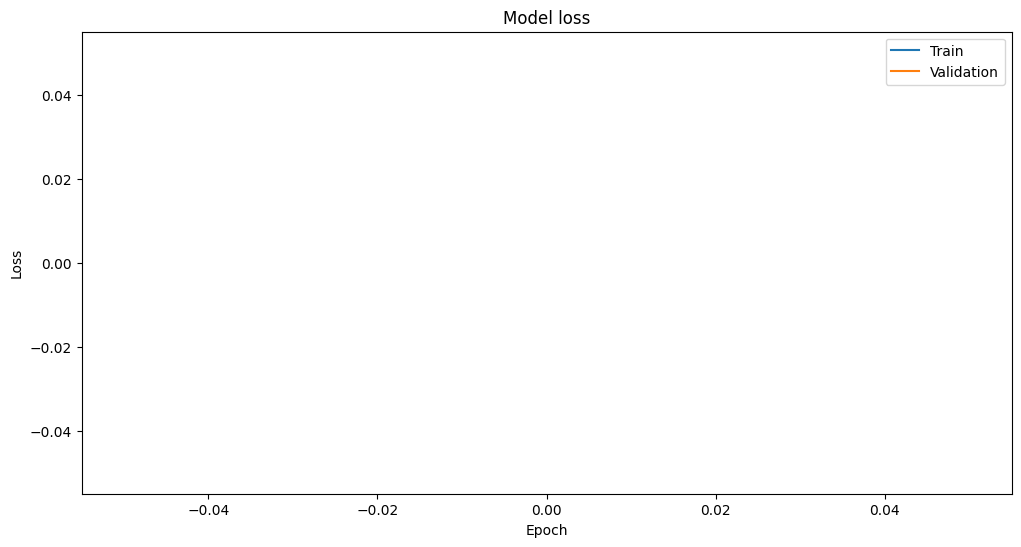

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 6s 6s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

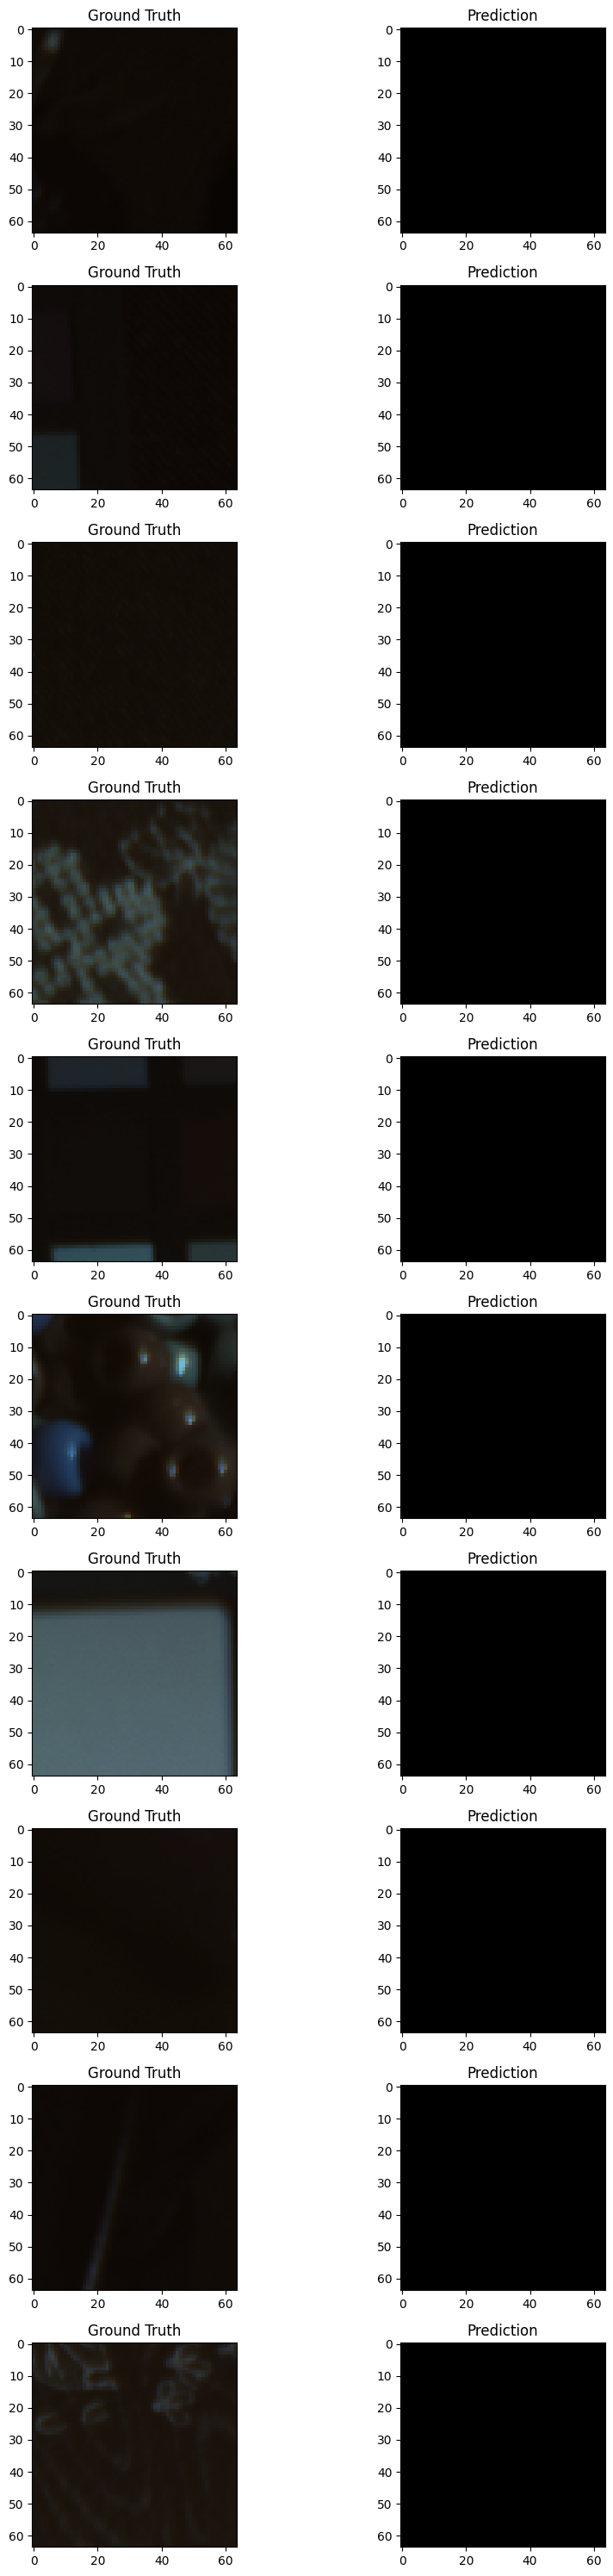

In [33]:
# Predict on the first 10 test images.
predictions = model.predict([X_hi_res_rgb_test[:10], X_low_res_hsi_test[:10]])

# Adjust the pixel values of the ground truth and predictions back to the original scale
y_test_adj = y_test[:10] * max_pixel_value
predictions_adj = predictions * max_pixel_value

# Plot the first 10 test images and their predicted images
fig, axs = plt.subplots(10, 2, figsize=(10, 30))
for i in range(10):
    # Ground truth - select the first three bands to represent RGB
    axs[i, 0].imshow(y_test_adj[i, :, :, :3].astype(int))
    axs[i, 0].set_title('Ground Truth')
    # Prediction - select the first three bands to represent RGB
    axs[i, 1].imshow(predictions_adj[i, :, :, :3].astype(int))
    axs[i, 1].set_title('Prediction')
plt.tight_layout()
plt.show()
